In [8]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K


num_classes = 10
epochs = 5


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.3
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
# the data, split between train and test sets
(x_test, y_test) ,(x_train, y_train) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

In [22]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009],
       dtype=int64))

In [23]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

In [24]:
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [25]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [26]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 17820 samples, validate on 108400 samples
Epoch 1/5
17820/17820 [==============================] - 5s 274us/step - loss: 0.1757 - accuracy: 0.7656 - val_loss: 0.1109 - val_accuracy: 0.8611
Epoch 2/5
17820/17820 [==============================] - 5s 262us/step - loss: 0.0966 - accuracy: 0.8965 - val_loss: 0.0871 - val_accuracy: 0.8977
Epoch 3/5
17820/17820 [==============================] - 4s 244us/step - loss: 0.0710 - accuracy: 0.9320 - val_loss: 0.0731 - val_accuracy: 0.9206
Epoch 4/5
17820/17820 [==============================] - 4s 237us/step - loss: 0.0542 - accuracy: 0.9527 - val_loss: 0.0626 - val_accuracy: 0.9308
Epoch 5/5
17820/17820 [==============================] - 4s 240us/step - loss: 0.0426 - accuracy: 0.9645 - val_loss: 0.0583 - val_accuracy: 0.9340


In [17]:
# model.save_weights('5_mnist.h5')

In [27]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 94.99%
* Accuracy on test set: 88.66%


In [9]:
y_pred

array([[0.00771919],
       [1.3799137 ],
       [0.00275083],
       ...,
       [0.925142  ],
       [0.01721895],
       [1.189351  ]], dtype=float32)

In [11]:
import matplotlib.pyplot as plt

def show_image(img):
    plt.imshow(img, cmap="gray")
    plt.show()

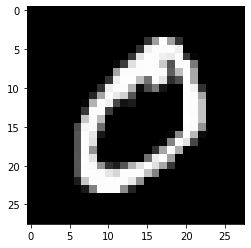

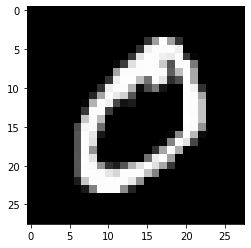

(None, None, 1)

In [15]:
show_image(tr_pairs[0][0]), show_image(tr_pairs[1][0]), tr_y[0]